In [1]:
import os
os.chdir("../../..")
import deepof.data

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
%load_ext autoreload
%autoreload 2

# DeepOF unsupervised pipeline: exploring the behavioral space

##### Tutorial index:
    
* Brief introduction to unsupervised analysis.
* Load your previous project.
* Running an unsupervised analysis with default parameters.
* Understanding the different available models.
* Temporal and global embeddings.
* Global separation dynamics.
* Exploring cluster enrichment across conditions.
* Exploring cluster dynamics across conditions.
* Interpreting clusters using SHAP.
* Exporting cluster video snippets.

### Brief introduction to unsupervised analysis

### Load your previous project

In [4]:
import pickle

# SI data
my_deepof_project = deepof.data.load_project("../../Desktop/deepOF_CSDS_tutorial_dataset/deepof_tutorial")
with open("deepof_SI_exp_conds.pkl", "rb") as handle:
    exp_conds = pickle.load(handle)
my_deepof_project._exp_conditions = {
    key: val for key, val in exp_conds.items() if key in my_deepof_project.get_quality().keys()
}

# Update project path to a local path
my_deepof_project._project_path = "../../Desktop/deepOF_CSDS_tutorial_dataset"
my_deepof_project._project_name = "deepof_tutorial"

In [5]:
# THIS SHOULD BE THE LAST SECTION OF THE FIRST TUTORIAL!

# Check scales across animals. Can we detect to which animal a given time series belongs to?
# Once happy with a solution, check that all animals show comparable cluster interpretations.

# Add preprocessing options to include multiple animals, concatenated and together in a graph

coords = my_deepof_project.get_coords(selected_id="B", center="Center", align="Spine_1")
preprocessed_coords, global_scaler = coords.preprocess(
    window_size=25,
    window_step=1,
    test_videos=1,
    scale="standard",
    handle_ids="concat", # "concat" uses bps from != animals as features, "split"
)

In [6]:
%%time
# SAME HERE: Last section of the last tutorial should explore tensor and graph preprocessing
from deepof.utils import connect_mouse_topview
import networkx as nx

graph_preprocessed_coords, G, to_preprocess, global_scaler = my_deepof_project.get_graph_dataset(
    # animal_id="B",
    center="Center",
    align="Spine_1",
    window_size=25,
    window_step=1,
    preprocess=True,
    scale="standard",
)

adjacency_matrix = nx.adjacency_matrix(G).todense()

# with open("graph_processed_dataset.pkl", "wb") as handle:
#     pickle.dump([pp, G, to_preprocess, global_scaler], handle, protocol=pickle.HIGHEST_PROTOCOL)

CPU times: user 3.08 s, sys: 1.06 s, total: 4.14 s
Wall time: 4.14 s


### Running an unsupervised analysis with default parameters

In [16]:
%%time
trained_model = my_deepof_project.deep_unsupervised_embedding(
    graph_preprocessed_coords, # Change to preprocessed_coords to use non-graph embeddings
    adjacency_matrix=adjacency_matrix,
    embedding_model="VaDE", # Can also be set to VQVAE and Contrastive
    epochs=10,
    encoder_type="recurrent", # Can also be set to TCN and transformer
    n_components=10,
    latent_dim=8,
    kl_warmup=10,
    kl_annealing_mode="linear",
    batch_size=1024,
    kmeans_loss=0.0,
    reg_cat_clusters=0.0,
    verbose=True, # Set to True to follow the training loop
    interaction_regularization=0.5,
)

2023-03-14 11:27:50.600491: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-14 11:27:50.600510: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-03-14 11:27:50.600674: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-03-14 11:28:12.719436: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Epoch 1/10
87/87 [==============================] - 104s 888ms/step - total_loss: 95.0516 - reconstruction_loss: 91.5043 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.0250 - kl_divergence: -5.8039 - kmeans_loss: 1.7393 - number_of_populated_clusters: 9.8670 - confidence_in_selected_cluster: 0.7335
Epoch 2/10


2023-03-14 11:29:57.727039: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


87/87 [==============================] - 84s 963ms/step - total_loss: 89.9189 - reconstruction_loss: 87.4926 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.0750 - kl_divergence: -4.6570 - kmeans_loss: 1.6133 - number_of_populated_clusters: 9.9288 - confidence_in_selected_cluster: 0.7133
Epoch 3/10


2023-03-14 11:31:22.641996: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


87/87 [==============================] - 93s 1s/step - total_loss: 86.4587 - reconstruction_loss: 84.6704 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.1250 - kl_divergence: -4.4040 - kmeans_loss: 1.6315 - number_of_populated_clusters: 9.9582 - confidence_in_selected_cluster: 0.7136
Epoch 4/10


2023-03-14 11:32:55.807120: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


87/87 [==============================] - 89s 1s/step - total_loss: 84.6526 - reconstruction_loss: 83.4771 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.1750 - kl_divergence: -4.2958 - kmeans_loss: 1.6675 - number_of_populated_clusters: 9.9634 - confidence_in_selected_cluster: 0.7274
Epoch 5/10


2023-03-14 11:34:25.466661: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


87/87 [==============================] - 119s 1s/step - total_loss: 83.6345 - reconstruction_loss: 83.0701 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.2250 - kl_divergence: -4.2371 - kmeans_loss: 1.6935 - number_of_populated_clusters: 9.9629 - confidence_in_selected_cluster: 0.7374
Epoch 6/10


2023-03-14 11:36:25.092603: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


87/87 [==============================] - 94s 1s/step - total_loss: 82.7907 - reconstruction_loss: 82.8260 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.2750 - kl_divergence: -4.2052 - kmeans_loss: 1.7116 - number_of_populated_clusters: 9.9578 - confidence_in_selected_cluster: 0.7439
Epoch 7/10


2023-03-14 11:37:59.588858: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


87/87 [==============================] - 90s 1s/step - total_loss: 81.8773 - reconstruction_loss: 82.6540 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.3250 - kl_divergence: -4.2429 - kmeans_loss: 1.7359 - number_of_populated_clusters: 9.9575 - confidence_in_selected_cluster: 0.7491
Epoch 8/10


2023-03-14 11:39:29.885569: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


87/87 [==============================] - 89s 1s/step - total_loss: 80.6611 - reconstruction_loss: 82.4591 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.3750 - kl_divergence: -4.4124 - kmeans_loss: 1.7905 - number_of_populated_clusters: 9.9618 - confidence_in_selected_cluster: 0.7565
Epoch 9/10


2023-03-14 11:40:59.405291: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


87/87 [==============================] - 88s 999ms/step - total_loss: 78.9891 - reconstruction_loss: 82.2770 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.4250 - kl_divergence: -4.7996 - kmeans_loss: 1.9110 - number_of_populated_clusters: 9.9616 - confidence_in_selected_cluster: 0.7705
Epoch 10/10


2023-03-14 11:42:28.068177: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


87/87 [==============================] - 87s 990ms/step - total_loss: 77.1632 - reconstruction_loss: 82.2340 - clustering_loss: 0.0000e+00 - prior_loss: 0.0000e+00 - kl_weight: 0.4750 - kl_divergence: -5.3644 - kmeans_loss: 2.1000 - number_of_populated_clusters: 9.9309 - confidence_in_selected_cluster: 0.7875
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True


2023-03-14 11:44:09.337388: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Epoch 1/10
 1/87 [..............................] - ETA: 17:53 - total_loss: 86.7364 - reconstruction_loss: 78.8222 - clustering_loss: -0.0097 - prior_loss: 0.0281 - kl_weight: 0.4994 - kl_divergence: -5.7787 - kmeans_loss: 2.2227 - number_of_populated_clusters: 9.8945 - confidence_in_selected_cluster: 0.7963

2023-03-14 11:44:22.256039: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-03-14 11:44:22.256053: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.


 2/87 [..............................] - ETA: 19:50 - total_loss: 88.4401 - reconstruction_loss: 80.7080 - clustering_loss: -0.0102 - prior_loss: 0.0294 - kl_weight: 0.4991 - kl_divergence: -5.7824 - kmeans_loss: 2.2240 - number_of_populated_clusters: 9.8946 - confidence_in_selected_cluster: 0.7964

2023-03-14 11:44:36.213569: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-03-14 11:44:36.247315: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-03-14 11:44:36.250049: I tensorflow/core/profiler/rpc/client/save_profile.cc:164] Collecting XSpace to repository: /Users/lucas_miranda/Desktop/deepOF_CSDS_tutorial_dataset/Trained_models/fit/deepof_unsupervised_VaDE_recurrent_encodings_input_type=coords_kmeans_loss=0.0_encoding=8_k=10_20230314-112750/plugins/profile/2023_03_14_11_44_36/MC-C9791E.local.xplane.pb


87/87 [==============================] - ETA: 0s - total_loss: 85.8790 - reconstruction_loss: 81.6307 - clustering_loss: -0.0500 - prior_loss: 0.1324 - kl_weight: 0.4779 - kl_divergence: -5.8347 - kmeans_loss: 2.2469 - number_of_populated_clusters: 9.8957 - confidence_in_selected_cluster: 0.8021

2023-03-14 11:46:06.683813: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


87/87 [==============================] - 117s 1s/step - total_loss: 85.8790 - reconstruction_loss: 81.6307 - clustering_loss: -0.0504 - prior_loss: 0.1335 - kl_weight: 0.4777 - kl_divergence: -5.8345 - kmeans_loss: 2.2469 - number_of_populated_clusters: 9.8957 - confidence_in_selected_cluster: 0.8021 - lr: 0.0010
Epoch 2/10
87/87 [==============================] - ETA: 0s - total_loss: 84.3694 - reconstruction_loss: 81.2983 - clustering_loss: -0.1215 - prior_loss: 0.3194 - kl_weight: 0.4449 - kl_divergence: -5.7779 - kmeans_loss: 2.2492 - number_of_populated_clusters: 9.8988 - confidence_in_selected_cluster: 0.8119

2023-03-14 11:47:43.938037: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


87/87 [==============================] - 97s 1s/step - total_loss: 84.3694 - reconstruction_loss: 81.2983 - clustering_loss: -0.1219 - prior_loss: 0.3204 - kl_weight: 0.4448 - kl_divergence: -5.7775 - kmeans_loss: 2.2492 - number_of_populated_clusters: 9.8988 - confidence_in_selected_cluster: 0.8120 - lr: 0.0010
Epoch 3/10
87/87 [==============================] - ETA: 0s - total_loss: 83.5972 - reconstruction_loss: 81.1668 - clustering_loss: -0.1815 - prior_loss: 0.4768 - kl_weight: 0.4253 - kl_divergence: -5.6931 - kmeans_loss: 2.2328 - number_of_populated_clusters: 9.8996 - confidence_in_selected_cluster: 0.8200

2023-03-14 11:49:29.775481: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


87/87 [==============================] - 105s 1s/step - total_loss: 83.5972 - reconstruction_loss: 81.1668 - clustering_loss: -0.1818 - prior_loss: 0.4776 - kl_weight: 0.4252 - kl_divergence: -5.6926 - kmeans_loss: 2.2327 - number_of_populated_clusters: 9.8996 - confidence_in_selected_cluster: 0.8201 - lr: 0.0010
Epoch 4/10
87/87 [==============================] - ETA: 0s - total_loss: 82.9874 - reconstruction_loss: 81.0383 - clustering_loss: -0.2331 - prior_loss: 0.6110 - kl_weight: 0.4160 - kl_divergence: -5.6029 - kmeans_loss: 2.2121 - number_of_populated_clusters: 9.8984 - confidence_in_selected_cluster: 0.8273

2023-03-14 11:51:14.348185: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


87/87 [==============================] - 104s 1s/step - total_loss: 82.9874 - reconstruction_loss: 81.0383 - clustering_loss: -0.2334 - prior_loss: 0.6117 - kl_weight: 0.4160 - kl_divergence: -5.6024 - kmeans_loss: 2.2120 - number_of_populated_clusters: 9.8985 - confidence_in_selected_cluster: 0.8273 - lr: 0.0010
Epoch 5/10
87/87 [==============================] - ETA: 0s - total_loss: 82.4308 - reconstruction_loss: 80.9498 - clustering_loss: -0.2780 - prior_loss: 0.7268 - kl_weight: 0.4148 - kl_divergence: -5.5229 - kmeans_loss: 2.1927 - number_of_populated_clusters: 9.8995 - confidence_in_selected_cluster: 0.8338

2023-03-14 11:52:50.040426: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


87/87 [==============================] - 95s 1s/step - total_loss: 82.4308 - reconstruction_loss: 80.9498 - clustering_loss: -0.2782 - prior_loss: 0.7274 - kl_weight: 0.4149 - kl_divergence: -5.5226 - kmeans_loss: 2.1926 - number_of_populated_clusters: 9.8995 - confidence_in_selected_cluster: 0.8338 - lr: 0.0010
Epoch 6/10
87/87 [==============================] - ETA: 0s - total_loss: 81.7689 - reconstruction_loss: 80.8955 - clustering_loss: -0.3175 - prior_loss: 0.8278 - kl_weight: 0.4203 - kl_divergence: -5.4774 - kmeans_loss: 2.1808 - number_of_populated_clusters: 9.8992 - confidence_in_selected_cluster: 0.8398

2023-03-14 11:54:14.846375: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


87/87 [==============================] - 84s 955ms/step - total_loss: 81.7689 - reconstruction_loss: 80.8955 - clustering_loss: -0.3177 - prior_loss: 0.8283 - kl_weight: 0.4203 - kl_divergence: -5.4775 - kmeans_loss: 2.1808 - number_of_populated_clusters: 9.8992 - confidence_in_selected_cluster: 0.8398 - lr: 0.0010
Epoch 7/10
87/87 [==============================] - ETA: 0s - total_loss: 80.8170 - reconstruction_loss: 80.9607 - clustering_loss: -0.3530 - prior_loss: 0.9166 - kl_weight: 0.4311 - kl_divergence: -5.5499 - kmeans_loss: 2.1963 - number_of_populated_clusters: 9.9002 - confidence_in_selected_cluster: 0.8455

2023-03-14 11:55:39.307803: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


87/87 [==============================] - 84s 956ms/step - total_loss: 80.8170 - reconstruction_loss: 80.9607 - clustering_loss: -0.3532 - prior_loss: 0.9170 - kl_weight: 0.4312 - kl_divergence: -5.5508 - kmeans_loss: 2.1966 - number_of_populated_clusters: 9.9002 - confidence_in_selected_cluster: 0.8456 - lr: 0.0010
Epoch 8/10
87/87 [==============================] - ETA: 0s - total_loss: 79.7115 - reconstruction_loss: 81.0918 - clustering_loss: -0.3853 - prior_loss: 0.9953 - kl_weight: 0.4465 - kl_divergence: -5.7372 - kmeans_loss: 2.2467 - number_of_populated_clusters: 9.8951 - confidence_in_selected_cluster: 0.8512

2023-03-14 11:57:01.182982: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


87/87 [==============================] - 81s 921ms/step - total_loss: 79.7115 - reconstruction_loss: 81.0918 - clustering_loss: -0.3855 - prior_loss: 0.9957 - kl_weight: 0.4466 - kl_divergence: -5.7385 - kmeans_loss: 2.2471 - number_of_populated_clusters: 9.8951 - confidence_in_selected_cluster: 0.8512 - lr: 0.0010
Epoch 9/10
87/87 [==============================] - ETA: 0s - total_loss: 78.3853 - reconstruction_loss: 81.2500 - clustering_loss: -0.4147 - prior_loss: 1.0655 - kl_weight: 0.4655 - kl_divergence: -6.0098 - kmeans_loss: 2.3293 - number_of_populated_clusters: 9.8723 - confidence_in_selected_cluster: 0.8566

2023-03-14 11:58:22.932079: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


87/87 [==============================] - 81s 924ms/step - total_loss: 78.3853 - reconstruction_loss: 81.2500 - clustering_loss: -0.4148 - prior_loss: 1.0659 - kl_weight: 0.4657 - kl_divergence: -6.0115 - kmeans_loss: 2.3299 - number_of_populated_clusters: 9.8721 - confidence_in_selected_cluster: 0.8566 - lr: 0.0010
Epoch 10/10
87/87 [==============================] - ETA: 0s - total_loss: 76.8669 - reconstruction_loss: 81.3993 - clustering_loss: -0.4413 - prior_loss: 1.1286 - kl_weight: 0.4878 - kl_divergence: -6.3449 - kmeans_loss: 2.4417 - number_of_populated_clusters: 9.8085 - confidence_in_selected_cluster: 0.8617

2023-03-14 11:59:48.627812: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


87/87 [==============================] - 85s 971ms/step - total_loss: 76.8669 - reconstruction_loss: 81.3993 - clustering_loss: -0.4414 - prior_loss: 1.1290 - kl_weight: 0.4879 - kl_divergence: -6.3469 - kmeans_loss: 2.4424 - number_of_populated_clusters: 9.8080 - confidence_in_selected_cluster: 0.8617 - lr: 0.0010
CPU times: user 2h 18min 7s, sys: 58min 55s, total: 3h 17min 2s
Wall time: 31min 58s


In [17]:
# Get embeddings, soft_counts, and breaks per video
embeddings, soft_counts, breaks = deepof.model_utils.embedding_per_video(
    my_deepof_project,
    to_preprocess, 
    trained_model,
    #animal_id="B",
    global_scaler=global_scaler,
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:39<00:00, 26.51s/it]


In [ ]:
# # Load results
import pickle
with open(
    "NatComm_trained_models/SI_single_animal_train_models/deepof_unsupervised_VaDE_encoder_recurrent_encodings_input=graph_k=10_latdim=8_changepoints_False_kmeans_loss=0.0_run=0.pkl", "rb"
) as handle:
    embeddings, soft_counts, breaks = pickle.load(handle)

In [ ]:
import numpy as np
embeddings = {key: val.numpy() for key, val in embeddings.items()}
soft_counts = {key: val.numpy() for key, val in soft_counts.items()}
breaks = {key: np.ones(soft_counts[key].shape[0]).astype(int) for key in soft_counts.keys()}

### Understanding the different available models

In [ ]:
# cons.vade.summary()

### Visualizing temporal and global embeddings

In [ ]:
# INCORPORATE AS A METHOD FOR EACH MODEL
# embeddings, soft_counts, breaks = deepof.model_utils.embedding_per_video(my_deepof_project, to_preprocess, cons)

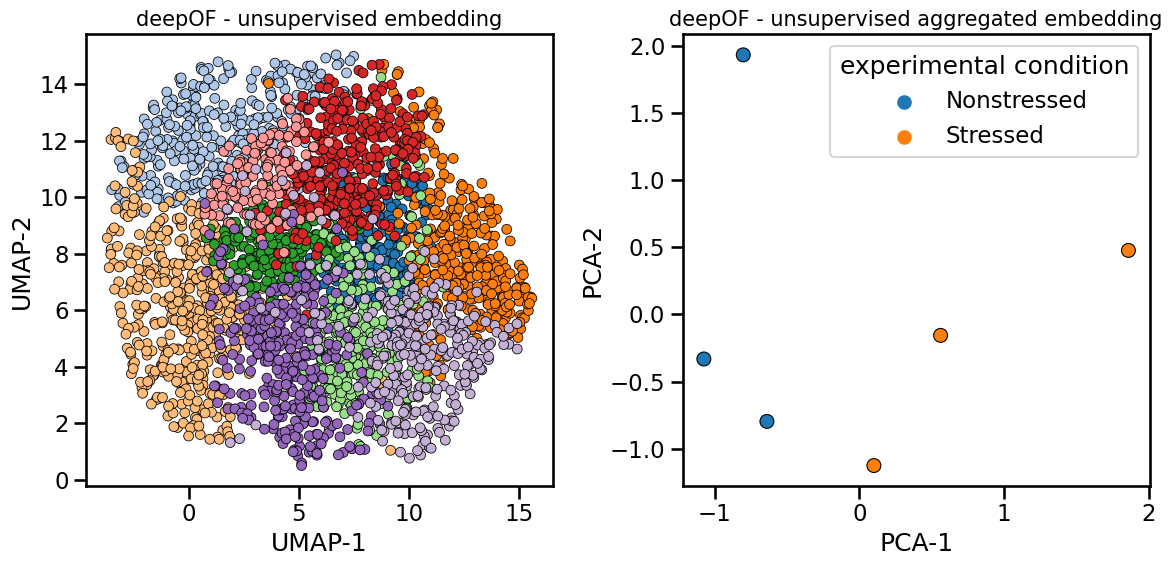

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
sns.set_context("talk")

deepof.visuals.plot_embeddings(
    my_deepof_project, 
    embeddings, 
    soft_counts,
    breaks,
    aggregate_experiments=False,
    samples=500,
    ax=ax1,
    save=False, # Set to True, or give a custom name, to save the plot
)

deepof.visuals.plot_embeddings(
    my_deepof_project,
    embeddings, 
    soft_counts,
    breaks,
    aggregate_experiments="time on cluster",
    exp_condition="CSDS",
    show_aggregated_density=False,
#     bin_index=4,
#     bin_size=25*120,
    ax=ax2,
    save=False, # Set to True, or give a custom name, to save the plot,
)

plt.tight_layout()
plt.show()

### Global separation dynamics

In [ ]:
%%time
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    
deepof.visuals.plot_distance_between_conditions(
    my_deepof_project,
    embeddings,
    soft_counts,
    breaks,
    "CSDS",
    distance_metric="wasserstein",
    n_jobs=-1,
)

plt.show()

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 16))


for i, ax in zip(range(4), [ax1, ax2, ax3, ax4]):

    deepof.visuals.plot_embeddings(
        my_deepof_project,
        embeddings, 
        soft_counts,
        breaks,
        aggregate_experiments="time on cluster",
        exp_condition="CSDS",
        show_aggregated_density=True,
        bin_index=i,
        bin_size=126,
        ax=ax,
        save=False, # Set to True, or give a custom name, to save the plot,
    )

plt.tight_layout()
plt.show()

### Exploring cluster enrichment across conditions

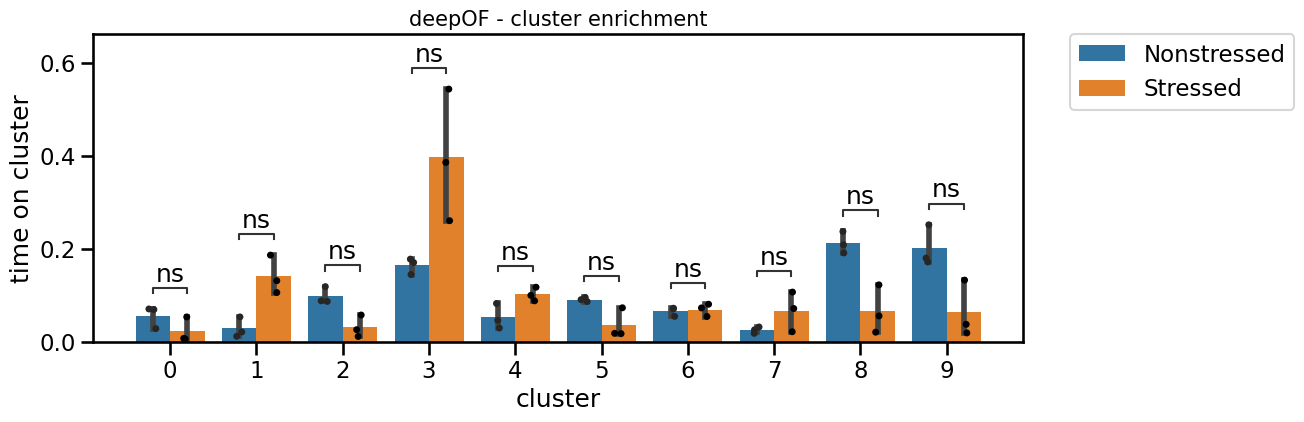

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

deepof.visuals.plot_enrichment(
    my_deepof_project,
    embeddings,
    soft_counts,
    breaks,
    normalize=True,
    bin_size=126,
    bin_index=0,
    add_stats="Mann-Whitney",
    exp_condition="CSDS",
    verbose=False,
    ax=ax,
)

In [26]:
from IPython import display

for i in range(10):
    
    print(i)
    video = deepof.visuals.animate_skeleton(
        my_deepof_project,
        embedding=embeddings,
        cluster_assignments=soft_counts,
        experiment_id="20191204_Day2_SI_JB08_Test_56",
        frame_limit=150,
        min_confidence=0.75,
        selected_cluster=i,
        dpi=60,
        center="arena",    
    )

    html = display.HTML(video)
    display.display(html)
    plt.close()

0


1


2


3


4


5


6


7


8


9


### Exploring cluster dynamics across conditions

In [ ]:
# Transition matrices and heatmaps
deepof.visuals.plot_transitions(
    my_deepof_project,
    embeddings,
    soft_counts,
   # cluster=False,
    visualization="heatmaps",
    exp_condition="CSDS",
)

deepof.visuals.plot_transitions(
    my_deepof_project,
    embeddings,
    soft_counts,
    visualization="networks",
    silence_diagonal=True,
    exp_condition="CSDS",
)

# TODO:

# Add option to use umap location on network plots

In [ ]:
# Entropy plots
fig, ax = plt.subplots(1, 1, figsize=(12, 2))

deepof.visuals.plot_stationary_entropy(
    my_deepof_project,
    embeddings,
    soft_counts,
    breaks,
    exp_condition="CSDS",
    ax=ax,
)

In [ ]:
fig = plt.figure(figsize=(12, 6))
sns.set_context("talk")

deepof.visuals.plot_gantt( # TODO: Add X axis in seconds, and parameter to overlay events as vertical black bars!
    my_deepof_project, # TODO: restrict time span! it looks noisy
    soft_counts=soft_counts,
    experiment_id="20191204_Day2_SI_JB08_Test_54",
)

### Combining supervised and unsupervised information

#### Visualize global embeddings using the retrieved traits.

#### Visualize animated unsupervised embeddings, coloured by specific traits.

### Interpreting clusters using SHAP

In [ ]:
%%time
csds_chunk_stats, hard_counts, sampled_breaks = deepof.post_hoc.annotate_time_chunks(
    deepof_project=my_deepof_project,
    soft_counts=soft_counts,
    breaks=breaks,
    #supervised_annotations=csds_OF_supervised_annotations,
    kin_derivative=1,
    window_size=13,
    include_distances=True,
    min_confidence=0.9,
    include_angles=True,
    include_areas=True,
    aggregate="mean",
    samples=1500,
)

In [ ]:
%%time
full_cluster_clf, cluster_gbm_performance, groups = deepof.post_hoc.train_supervised_cluster_detectors(
    csds_chunk_stats, hard_counts, sampled_breaks, n_folds=5, verbose=2,
)

In [ ]:
plt.figure(figsize=(8, 6))
sns.set_context("notebook")

deepof.visuals.plot_cluster_detection_performance(
    my_deepof_project,
    csds_chunk_stats,
    cluster_gbm_performance,
    hard_counts,
    groups,
    visualization="confusion_matrix",
)

In [ ]:
plt.figure(figsize=(8, 6))
sns.set_context("talk")

deepof.visuals.plot_cluster_detection_performance(
    my_deepof_project,
    csds_chunk_stats,
    cluster_gbm_performance,
    hard_counts,
    groups,
    visualization="balanced_accuracy",
    save=False,
)

In [ ]:
shap_values, explainer, data_to_explain = deepof.post_hoc.explain_clusters(
    csds_chunk_stats, hard_counts, full_cluster_clf, samples=100
)

In [ ]:
from matplotlib import colors as plt_colors
from ipywidgets import interact
import copy
import numpy as np

# Plot swarm plots per cluster
@interact()
def plot_shap_swarm_per_cluster(
    cluster=["all"] + list(range(10)), save=False,
):
    
    deepof.visuals.plot_shap_swarm_per_cluster(
        my_deepof_project, 
        data_to_explain, 
        shap_values, cluster, 
        save=save,
        show=False,
    )
    
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

### Exporting cluster video snippets

In [ ]:
deepof.visuals.export_annotated_video( # TODO: add exp condition filters to output names
    my_deepof_project,
    soft_counts,
    breaks,
    frame_limit_per_video=100,
)